In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from ToyTrajectoryNet.losses import MMD_loss, OT_loss, Density_loss, Local_density_loss
from ToyTrajectoryNet.utils import group_extract, sample, to_np, generate_steps
from ToyTrajectoryNet.models import ToyModel, make_model, Autoencoder
from ToyTrajectoryNet.plots import plot_comparision, plot_losses
from ToyTrajectoryNet.train import train, train_ae
from ToyTrajectoryNet.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from ToyTrajectoryNet.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data, relabel_data
)
from ToyTrajectoryNet.ode import NeuralODE, ODEF
from ToyTrajectoryNet.geo import DiffusionDistance, old_DiffusionDistance
from ToyTrajectoryNet.exp import setup_exp
from ToyTrajectoryNet.eval import generate_plot_data

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn
import random

from tqdm.notebook import tqdm
from phate import PHATE

# for geodesic learning
from sklearn.gaussian_process.kernels import RBF
from sklearn.manifold import MDS

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load dataset

In [2]:
phate_dims = None
round_labels=None
use_gaussian=None
add_noise_directly=None
add_noise_after_phate=None
scale_factor=None

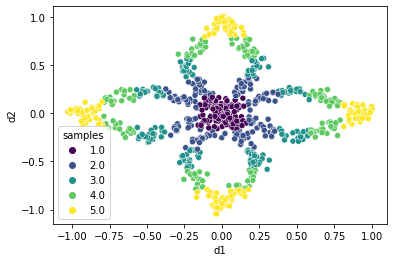

In [3]:
df = make_diamonds()
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis');

# Train autoencoder or the geodesic embedding

In [4]:
# if hold one out is True and hold_out not 'random', we train the DAE without this sample
groups = sorted(df.samples.unique())
hold_one_out = False
hold_out = 5

if hold_one_out is True and hold_out in groups:
    df_ho = df.drop(df[df['samples']==hold_out].index, inplace=False)
    groups = sorted(df_ho.samples.unique())

In [5]:
from sklearn.gaussian_process.kernels import RBF
import time
start_time_geo = time.time()
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

use_cuda = torch.cuda.is_available()

model_features = len(df.columns) - 1
encoder_layers = [model_features,8,32]

dae = Autoencoder(
    encoder_layers = encoder_layers,
    decoder_layers = encoder_layers[::-1],
    activation='ReLU'
)
optimizer = torch.optim.AdamW(dae.parameters())
dae.cuda() if use_cuda else None

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=2, bias=True)
  )
)

dist=None and recon=True for DAE or dist=DiffusionDistance(knn=40,t_max=3) recon=False for geo embedding

In [6]:
old_DiffusionDistance(RBF(5.0),t_max=3),DiffusionDistance(knn=40,t_max=3,symmetrize=True)

(<ToyTrajectoryNet.geo.old_DiffusionDistance at 0x7ff0ddf61198>,
 <ToyTrajectoryNet.geo.DiffusionDistance at 0x7ff0ddf611d0>)

In [7]:
dist = old_DiffusionDistance(RBF(0.1),t_max=5)
n_epochs_emb=1000
samples_size_emb = (30,)
recon_emb = False
if hold_one_out:
    losses = train_ae(
            dae, df_ho, groups, optimizer, n_epochs=n_epochs_emb, sample_size=samples_size_emb,
        noise_min_scale=0.09, noise_max_scale=0.15, dist=dist, recon=recon_emb
    )
else:
    losses = train_ae(
        dae, df, groups, optimizer, n_epochs=n_epochs_emb, sample_size=samples_size_emb,
    noise_min_scale=0.09, noise_max_scale=0.15, dist=dist, recon=recon_emb
    )
run_time_geo = time.time() - start_time_geo
print(run_time_geo)

  0%|          | 0/1000 [00:00<?, ?it/s]

Train loss dist: 8.30711
Train loss dist: 5.81301
Train loss dist: 4.86597
Train loss dist: 4.16156
Train loss dist: 3.74496
Train loss dist: 3.77133
Train loss dist: 3.50944
Train loss dist: 3.33885
Train loss dist: 3.53872
Train loss dist: 3.03275
Train loss dist: 3.03338
Train loss dist: 2.86131
Train loss dist: 2.80113
Train loss dist: 2.62133
Train loss dist: 2.55013
Train loss dist: 2.55664
Train loss dist: 2.52149
Train loss dist: 2.44778
Train loss dist: 2.54678
Train loss dist: 2.59256
123.77468252182007


# Specify parameters

Note: if we trained geo and reconstruction at the same time, then we use geo even if 'geo_emb=None'

In [21]:
torch.manual_seed(10)
random.seed(10)
np.random.seed(10)

#exp_name = 'petal_leave{}'.format(hold_out)
exp_name='petal_penalty_lowenergy'

use_geo = True
use_dae = False
use_density_loss = True
lambda_density = 30
top_k=5
hinge_value = 0.01
use_penalty_energy=True
lambda_energy=0.01

small_model = True
use_cuda = torch.cuda.is_available()

emb_features = 5
model_features = len(df.columns) - 1 if not use_dae else encoder_layers[-1]


layers = [16,32,16]
activation = 'LeakyReLU'
ode_method = 'rk4'
n_aug=2
#sde_scales=None
sde_scales = len(groups)*[0.1] # if use dopri5 or any adaptative solver, one needs to increase the number of scales, e.g. (len(groups)+10)*[0.2]

if use_geo:
    geoemb = dae.encoder
    if use_cuda:
        geoemb = geoemb.cuda()
else:
    geoemb=None
if use_dae:
    autoencoder = dae
    if use_cuda:
        autoencoder = autoencoder.cuda()
else:
    autoencoder=None
    
if not small_model:
    model = make_model(model_features, [32, 64, 128, 64, 32], activation=activation)
else:
    model = make_model(model_features, layers, activation=activation,method=ode_method, rtol=0.001,atol=0.001,scales=sde_scales, n_aug=n_aug)
if use_cuda:
    model = model.cuda()

In [22]:
print(model)

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


In [23]:
sample_with_replacement = False
sample_size=(60, )
n_samples=1

n_local_epochs = 30
n_epochs = 0
n_post_local_epochs = 0

n_batches = 20

optimizer = torch.optim.AdamW(model.parameters())

criterion_name = 'ot'
if criterion_name == 'mmd':
    criterion = MMD_loss()
else:
    criterion = OT_loss()

local_losses = {f'{t0}:{t1}':[] for (t0, t1) in steps}
batch_losses = []
globe_losses = []


use_local_density = False


n_points = 100
n_trajectories = 100
n_bins = 100

add_noise = False
noise_scale = 0.09
use_gaussian = False

In [24]:
opts = {
    'phate_dims': phate_dims,
    'round_labels': round_labels,
    'use_gaussian': use_gaussian,
    'add_noise_directly': add_noise_directly,
    'add_noise_after_phate': add_noise_after_phate,
    'scale_factor': scale_factor,
    'use_cuda': use_cuda,
    'emb_features': emb_features,
    'model_features': model_features,
    'small_model': small_model,
    'exp_name': exp_name,
    'groups': groups,
    'steps': steps,
    'sample_with_replacement': sample_with_replacement,
    'sample_size': sample_size,
    'use_geo': use_geo,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'n_batches': n_batches,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'hinge_value': hinge_value,
    'use_density_loss': use_density_loss,
    'use_local_density': use_local_density,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'add_noise': add_noise,
    'noise_scale': noise_scale,
    'use_gaussian': use_gaussian,
    'autoencoder': autoencoder,
    'n_samples': n_samples,
    'activation': activation,
    'layer': layers,
    'ode_solver': ode_method,
    'lambda_density':lambda_density,
    'top_k':top_k,
    'use_dae': use_dae,
    'sde_scales': sde_scales,
    'n_augmented_ode': n_aug,
    'hold_out':hold_out,
    'encoder_layers': encoder_layers,
    'n_epochs_emb': n_epochs_emb,
    'samples_size_emb': samples_size_emb,
    'recon_emb': recon_emb,
    'dist': dist, 
    'use_penalty_energy':use_penalty_energy,
    'lambda_energy':lambda_energy
}

In [25]:
exp_dir, logger = setup_exp(RES_DIR, opts, exp_name) 

In [26]:
import time
start_time = time.time()
for epoch in tqdm(range(n_local_epochs), desc='Pretraining Epoch'):
    l_loss, b_loss, g_loss = train(
        model, df, groups, optimizer, n_batches, 
        criterion = criterion, use_cuda = use_cuda,
        local_loss=True, global_loss=False, apply_losses_in_time=True,
        hold_one_out=hold_one_out, hold_out=hold_out, 
        hinge_value=hinge_value,
        use_density_loss = use_density_loss, use_local_density = use_local_density,       
        top_k = top_k, lambda_density = lambda_density,  lambda_density_local = 1.0, 
        geo_emb = geoemb, use_emb = use_geo, sample_size=sample_size, 
        sample_with_replacement=sample_with_replacement, logger=logger, autoencoder=autoencoder, n_samples=n_samples,
        add_noise=add_noise, noise_scale=noise_scale, use_gaussian=use_gaussian,use_penalty=use_penalty_energy,lambda_energy=lambda_energy
    )
    for k, v in l_loss.items():  
        local_losses[k].extend(v)
    batch_losses.extend(b_loss)
    globe_losses.extend(g_loss)
    
for epoch in tqdm(range(n_epochs), desc='Epoch'):
    l_loss, b_loss, g_loss = train(
        model, df, groups, optimizer, n_batches, 
        criterion = criterion, use_cuda = use_cuda,
        local_loss=False, global_loss=True, apply_losses_in_time=True,
        hold_one_out=hold_one_out, hold_out=hold_out, 
        hinge_value=hinge_value,
        use_density_loss = use_density_loss, use_local_density = use_local_density,       
        top_k = top_k, lambda_density = lambda_density, lambda_density_local = 1.0, 
        geo_emb =  geoemb, use_emb = use_geo, sample_size=sample_size, 
        sample_with_replacement=sample_with_replacement, logger=logger, autoencoder=autoencoder, n_samples=n_samples,
        add_noise=add_noise, noise_scale=noise_scale, use_gaussian=use_gaussian,use_penalty=use_penalty_energy,lambda_energy=lambda_energy
    )

    for k, v in l_loss.items():  
        local_losses[k].extend(v)
    batch_losses.extend(b_loss)
    globe_losses.extend(g_loss)
    
for epoch in tqdm(range(n_post_local_epochs), desc='Posttraining Epoch'):
    l_loss, b_loss, g_loss = train(
        model, df, groups, optimizer, n_batches, 
        criterion = criterion, use_cuda = use_cuda,
        local_loss=True, global_loss=False, apply_losses_in_time=True,
        hold_one_out=hold_one_out, hold_out=hold_out, 
        hinge_value=hinge_value,
        use_density_loss = use_density_loss, use_local_density = use_local_density,       
        top_k = top_k, lambda_density = lambda_density,  lambda_density_local = 1.0, 
        geo_emb =  geoemb, use_emb = use_geo, sample_size=sample_size, 
        sample_with_replacement=sample_with_replacement, logger=logger, autoencoder=autoencoder, n_samples=n_samples,
        add_noise=add_noise, noise_scale=noise_scale, use_gaussian=use_gaussian,use_penalty=use_penalty_energy,lambda_energy=lambda_energy
    )
    for k, v in l_loss.items():  
        local_losses[k].extend(v)
    batch_losses.extend(b_loss)
    globe_losses.extend(g_loss)
run_time = time.time() - start_time + run_time_geo if use_geo or use_dae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0it [00:00, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

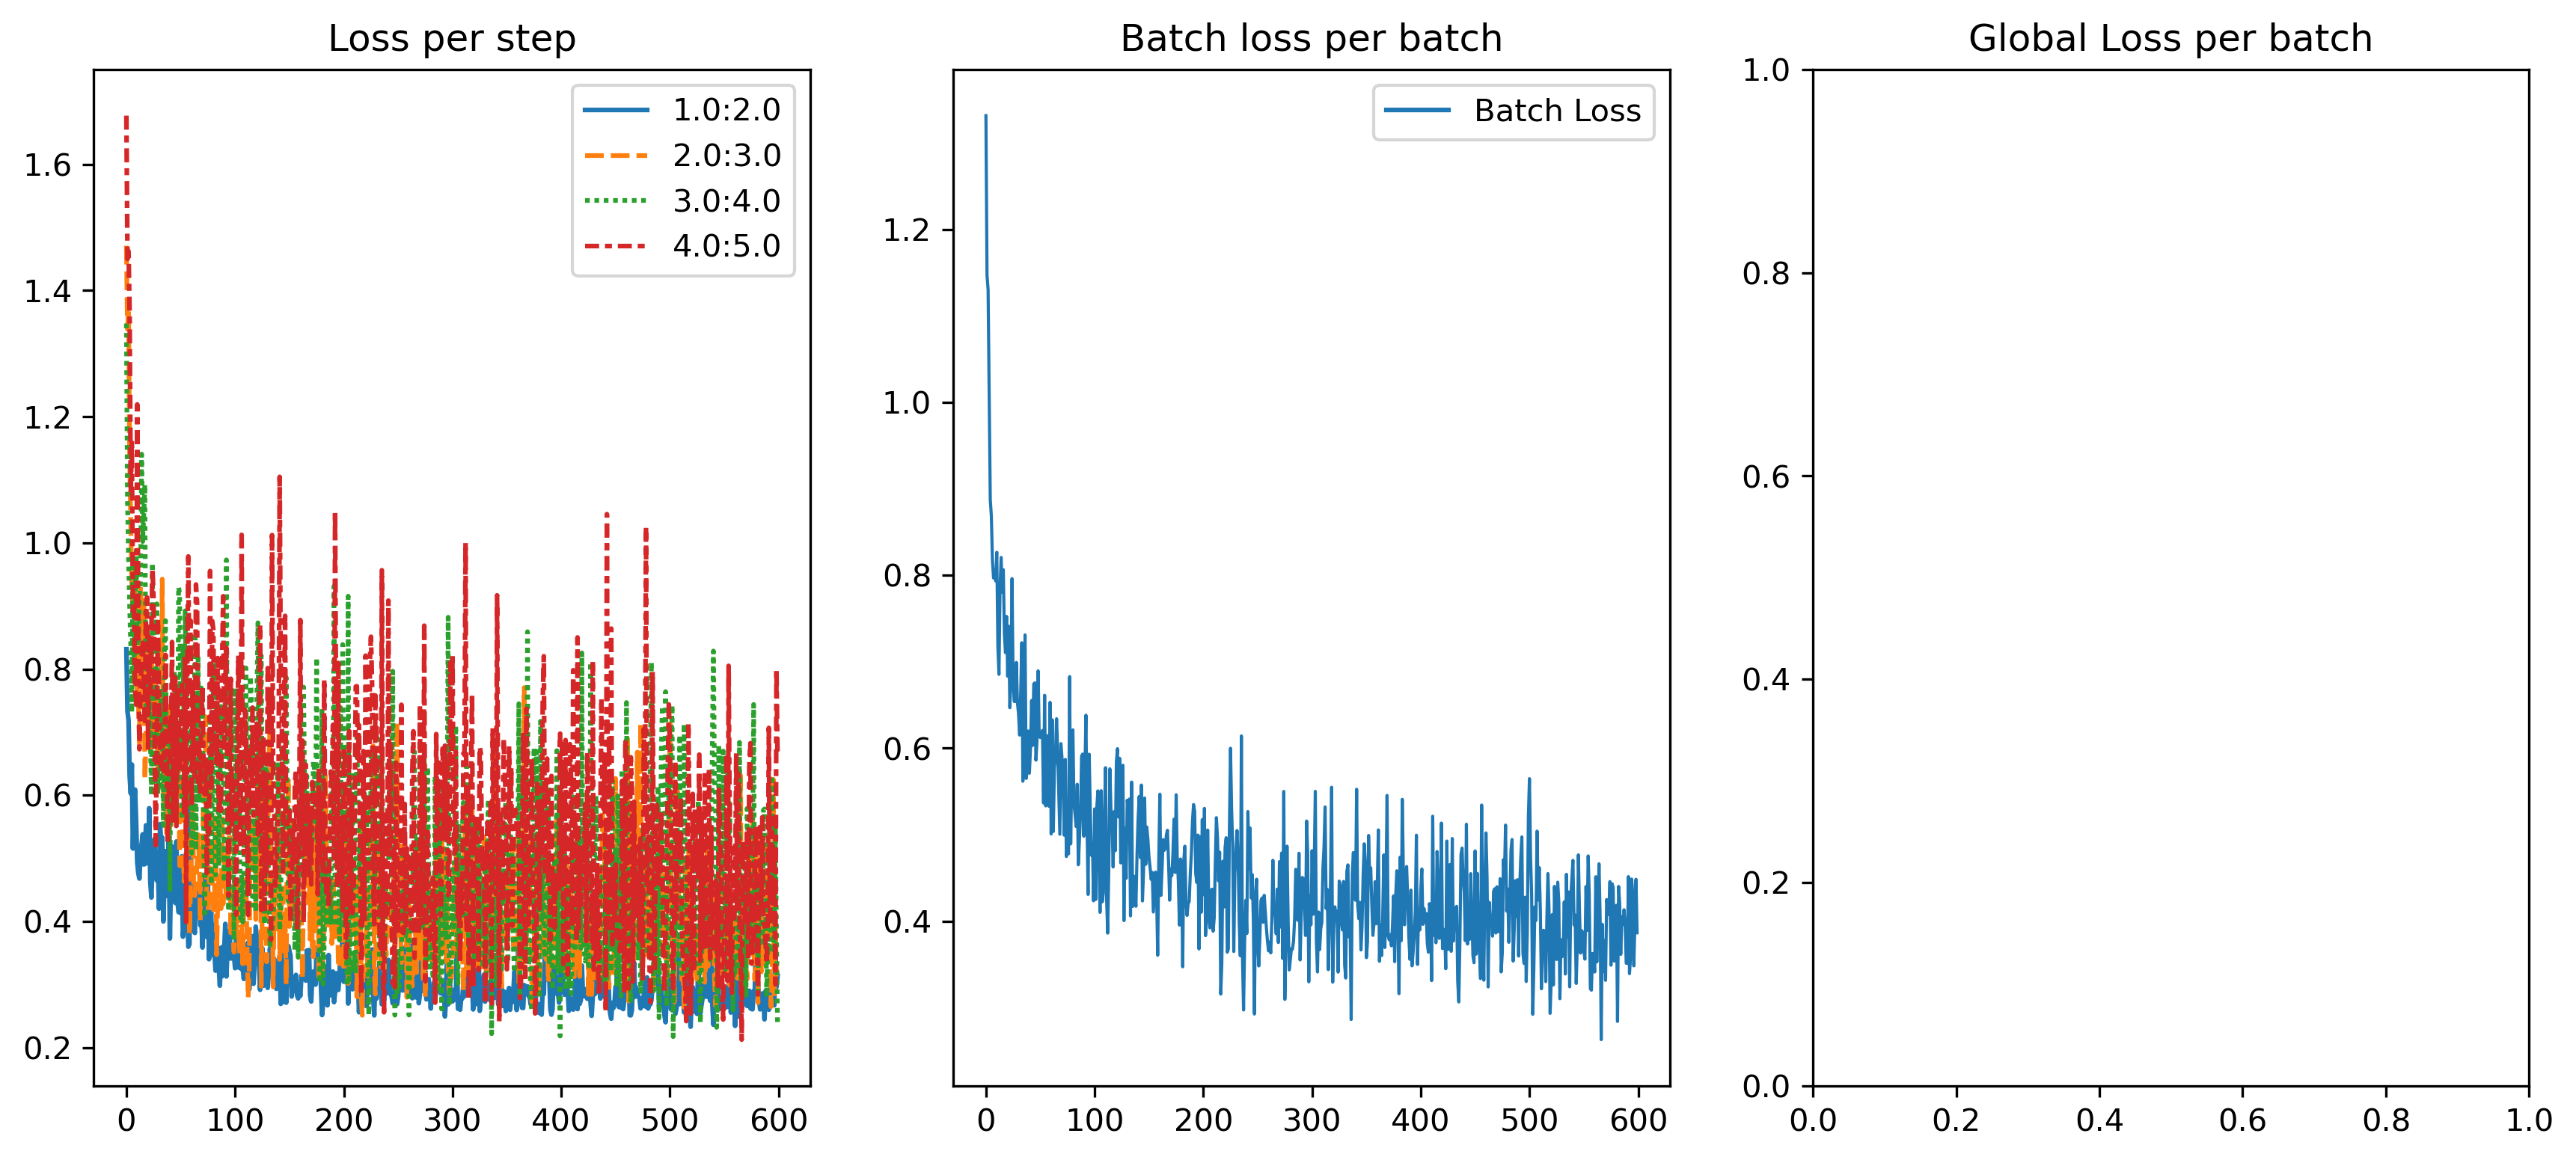

In [30]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=True, path=exp_dir, file='losses.png'
)

In [31]:
generated, trajectories = generate_plot_data(
    model, df, n_points, n_trajectories, n_bins=100, 
    sample_with_replacement=sample_with_replacement, use_cuda=use_cuda, samples_key='samples', autoencoder=autoencoder
)
if autoencoder is not None:
    if use_cuda:
        generated, trajectories = torch.Tensor(generated).cuda(), torch.Tensor(trajectories).cuda()
    else:
        generated, trajectories = torch.Tensor(generated), torch.Tensor(trajectories)
    generated, trajectories = autoencoder.decoder(generated).detach().cpu(), autoencoder.decoder(trajectories).detach().cpu() 

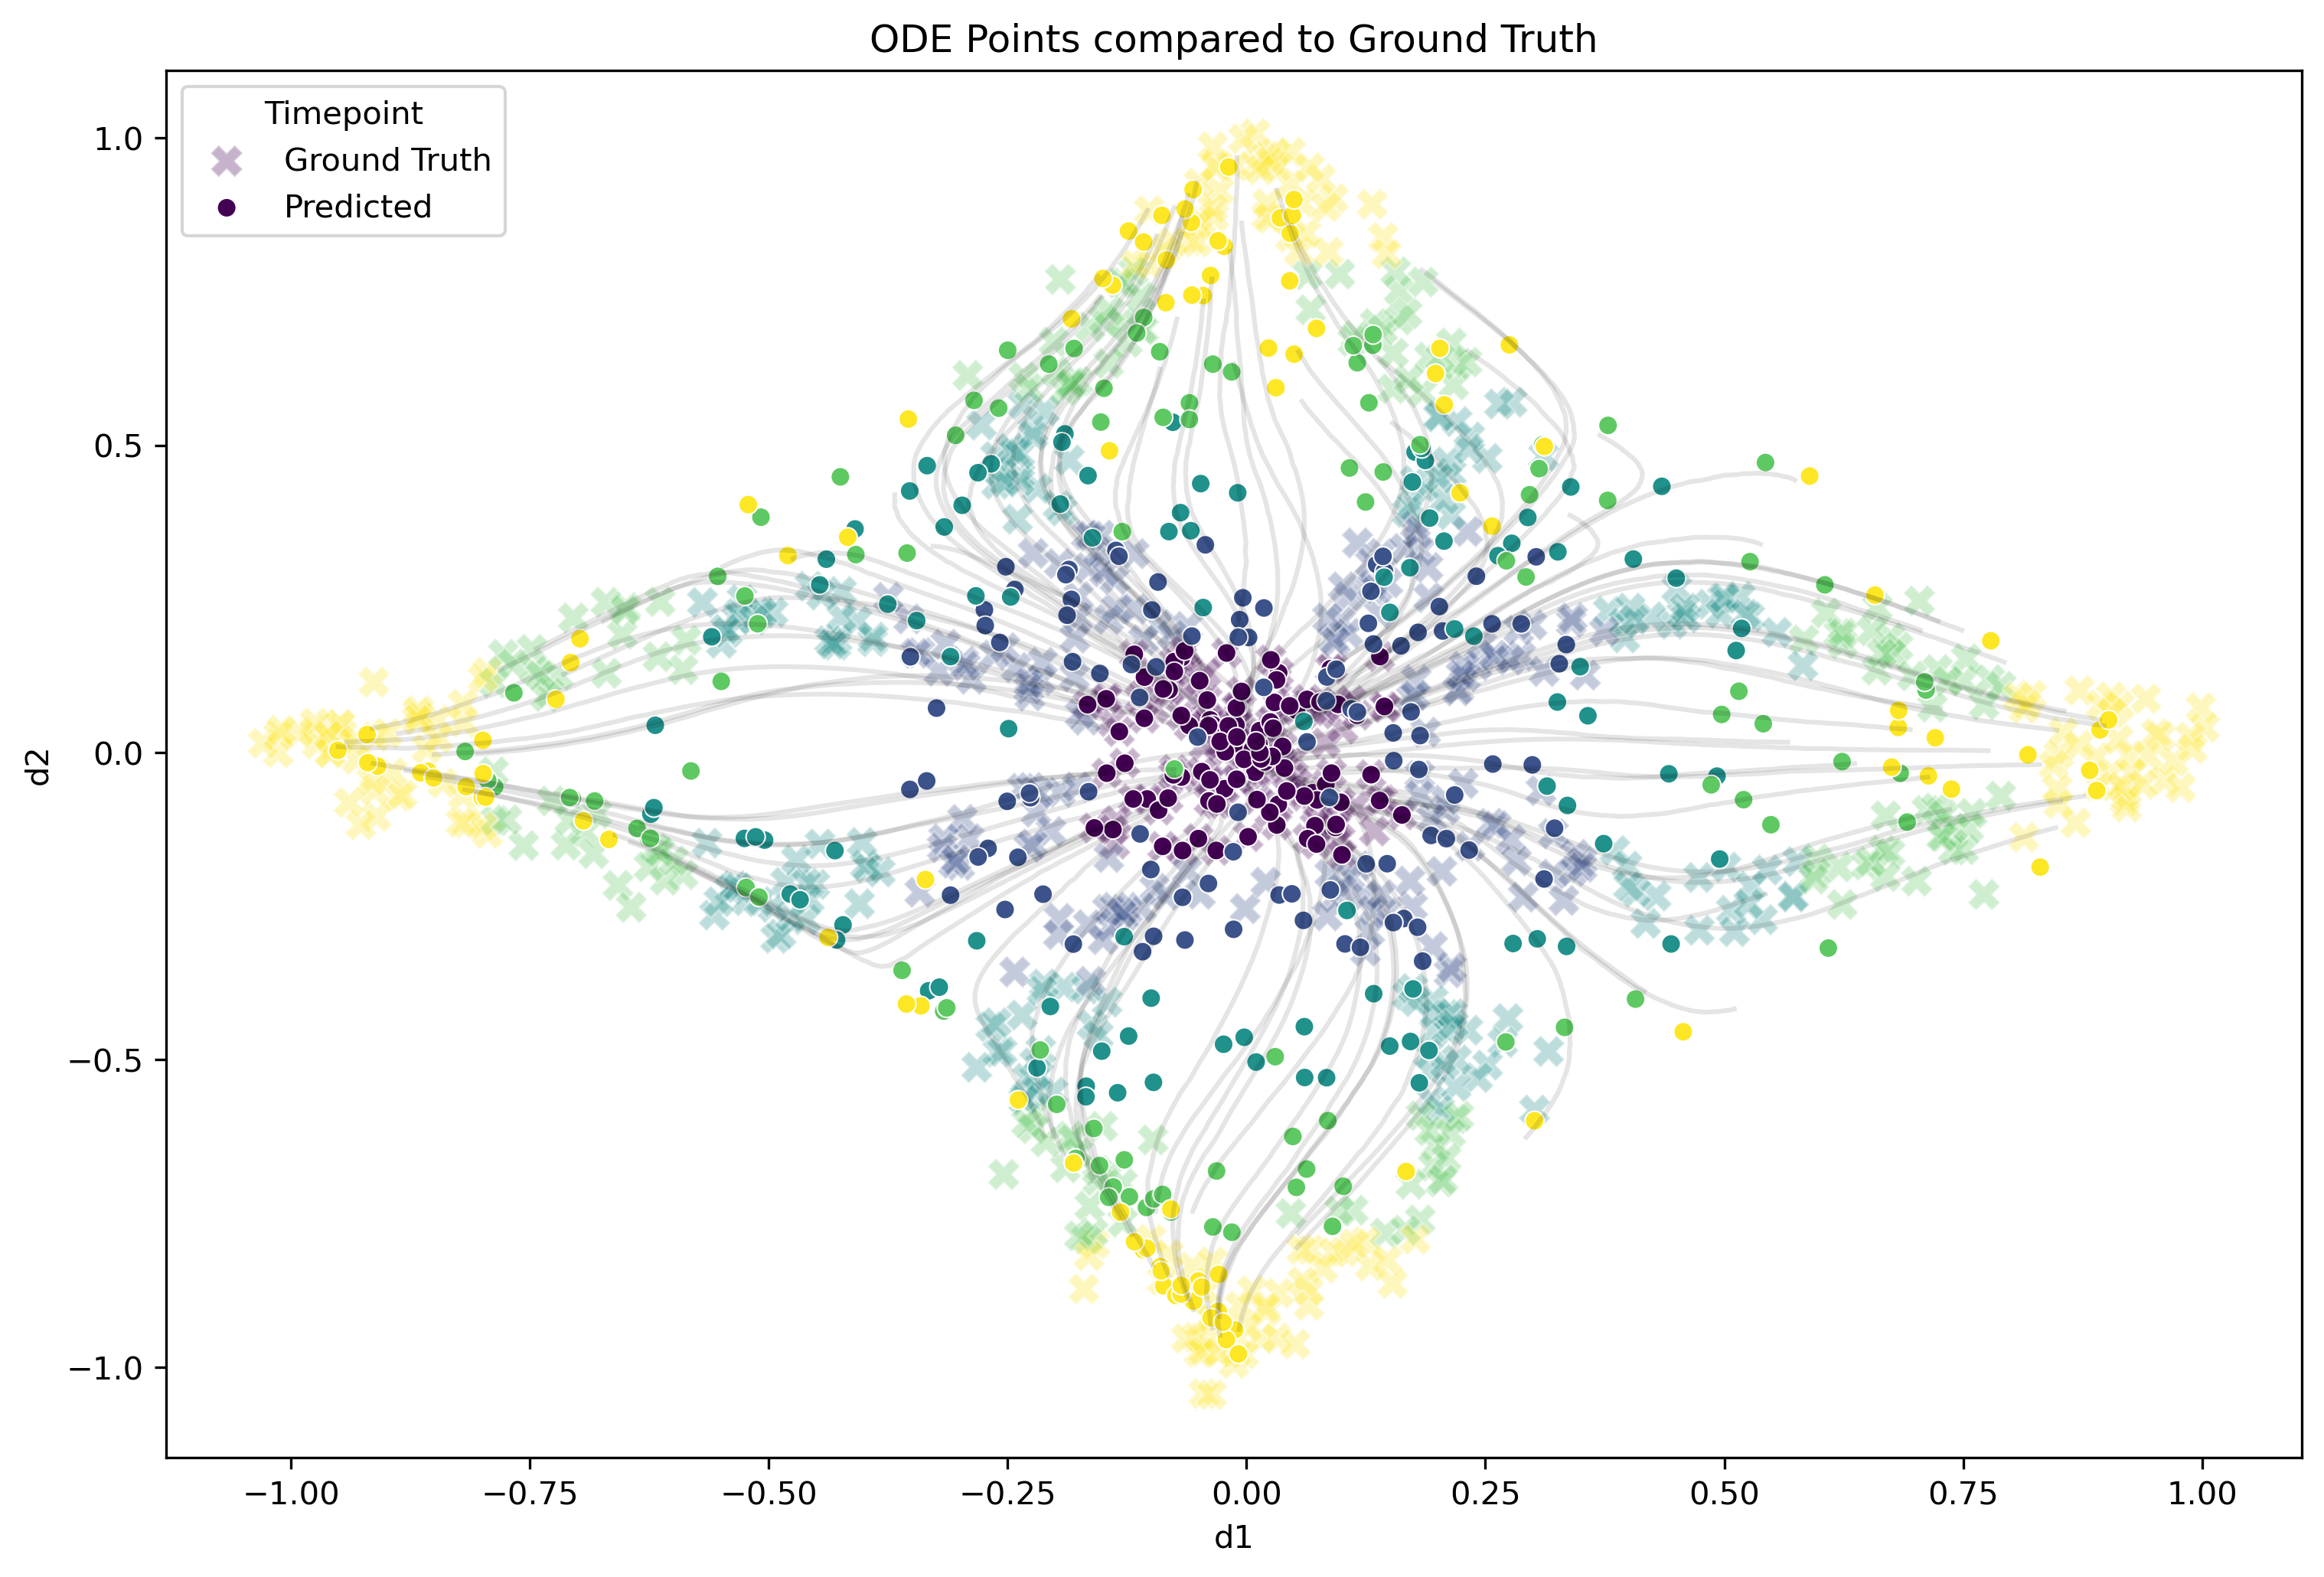

In [32]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='2d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=False
)

In [156]:
# saving the trajectories and generated points
np.save(os.path.join(exp_dir,'trajectories_leave{}.npy'.format(hold_out)),trajectories)
np.save(os.path.join(exp_dir,'generated_leave{}.npy'.format(hold_out)),generated)

In [140]:
#Temporary fix for the logger
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

In [139]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

func.alpha tensor([0.0799, 0.1886, 0.1069, 0.1007, 0.0701], device='cuda:0')
func.seq.0.weight tensor([[-0.4875,  0.0199, -0.0137,  0.0996, -0.2478],
        [-0.6254,  0.1715,  0.5518,  0.1020, -0.1469],
        [ 0.0159, -0.4757,  0.2853,  0.0496,  0.1697],
        [ 0.9338, -0.0669, -0.0425,  0.0996, -0.0028],
        [ 0.2205, -0.7075, -0.2221, -0.3897, -0.4238],
        [-1.1978,  0.1383, -0.0969, -0.4063,  0.1899],
        [ 0.6832,  0.6377,  0.2892,  0.1468,  0.1908],
        [-0.9568,  1.0386,  0.1089,  0.3737,  0.1328],
        [-0.1394,  0.3982,  0.0465, -0.1260,  0.0652],
        [-0.7078,  0.0090,  0.4043, -0.3384, -0.0199],
        [-0.6934,  1.0588, -0.0201,  0.0828, -0.1183],
        [ 0.6556,  0.1758,  0.1106,  0.3170,  0.3956],
        [-0.8978, -0.6916,  0.0737,  0.1364,  0.0988],
        [ 0.5467,  0.1858, -0.3893, -0.2966,  0.3360],
        [ 0.5753, -0.3253, -0.3187,  0.1516, -0.3097],
        [-0.0201, -1.0796,  0.1770, -0.1477, -0.2423]], device='cuda:0')
func.se